In [289]:
import librosa
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [290]:
import re
def extract_prefix(filename):
    # Regular expression to match the first part of the filename before numbers or "_"
    match = re.match(r'^[a-zA-Z]+', filename)
    if match:
        return match.group(0)  # Return the matched part
    return None

In [291]:
import os
base_path = '/content/drive/MyDrive/audio_intern/'
audio_dict = {}
audios = os.listdir(base_path)
for audio in audios:
  prefix = extract_prefix(audio.title())
  if prefix in audio_dict:
    audio_dict[prefix].append(base_path + audio)
  else:
    audio_dict[prefix] = [base_path+audio]

In [292]:
def apply_PCA(train,test,n_components=8):
  pca = PCA(n_components=n_components)
  concat = np.concatenate((train,test),axis=0)
  pca_model = pca.fit(concat)
  reduced_train = pca_model.transform(train)
  reduced_test = pca_model.transform(test)
  return reduced_train,reduced_test

In [293]:
def plot_heatmap(similarity,audio_dict=audio_dict):
  labels = audio_dict.keys()
  # Plot heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(similarity,xticklabels=labels,yticklabels=labels, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
  plt.title("Heatmap of Speakers")
  plt.xlabel("Speakers")
  plt.ylabel("Speakers")
  plt.gca().invert_xaxis()
  plt.show()

## Using Librosa

In [294]:
def extract_embedding(path):
    audio, sample_rate = librosa.load(path, sr=16000)
    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  # Shape: (n_mfcc, n_frames)

    # Temporal averaging
    mfcc_avg = mfcc.mean(axis=1)
    return mfcc_avg

In [295]:
train_embeds = []
test_embeds = []
for key,value in audio_dict.items():
  train_embeds.append(extract_embedding(value[0]))
  test_embeds.append(extract_embedding(value[1]))

<ipython-input-294-f087adfe8f29>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(path, sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-294-f087adfe8f29>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(path, sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-294-f087adfe8f29>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(path, sr=16000)
/usr/local/lib/python

In [296]:
reduced_train,reduced_test = apply_PCA(train_embeds,test_embeds,8)

In [297]:
reduced_train.shape

(8, 8)

In [298]:
reduced_test.shape

(8, 8)

In [308]:
similarity = cosine_similarity(reduced_train,reduced_test)

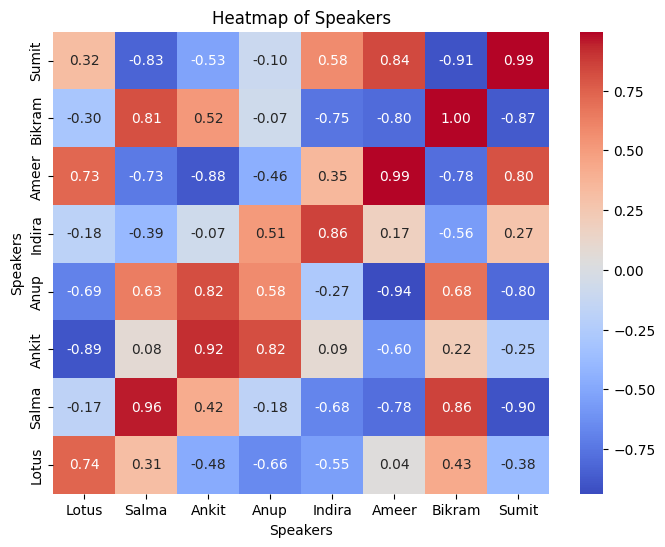

In [309]:
plot_heatmap(similarity,audio_dict=audio_dict)

## Using TorchAudio

In [301]:
def extract_embedding_torchaudio(audio_path):
  waveform, sample_rate = torchaudio.load(audio_path)
  if waveform.shape[0] > 1:
      waveform = waveform.mean(dim=0, keepdim=True)
  mfcc_transform = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=40)
  mfcc = mfcc_transform(waveform)
  return mfcc.mean(dim=2).squeeze().numpy()

In [302]:
train_embeds_torch = []
test_embeds_torch = []
for key,value in audio_dict.items():
  train_embeds_torch.append(extract_embedding_torchaudio(value[0]))
  test_embeds_torch.append(extract_embedding_torchaudio(value[1]))

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [331]:
reduced_train_torch,reduced_test_torch = apply_PCA(train_embeds_torch,test_embeds_torch,8)

In [332]:
similarity_torch = cosine_similarity(reduced_train_torch,reduced_test_torch)

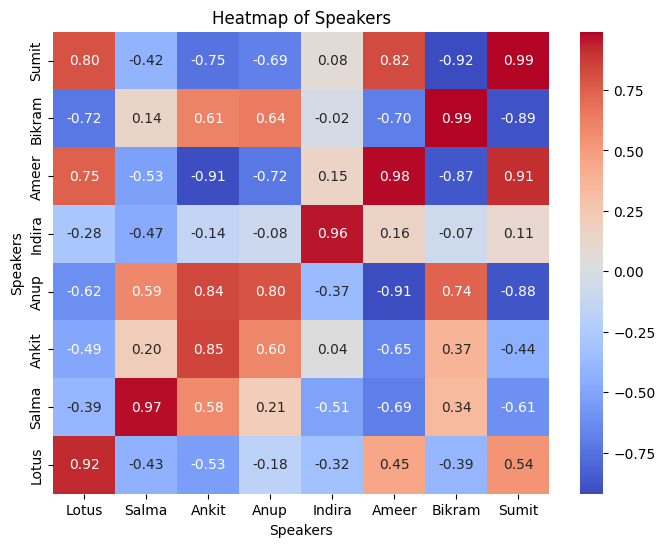

In [333]:
plot_heatmap(similarity_torch,audio_dict=audio_dict)